/home/tiger/miniforge3/envs/beam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded embeddings: (24931, 128)


/home/tiger/miniforge3/envs/beam/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D embedding shape: (24931, 2)


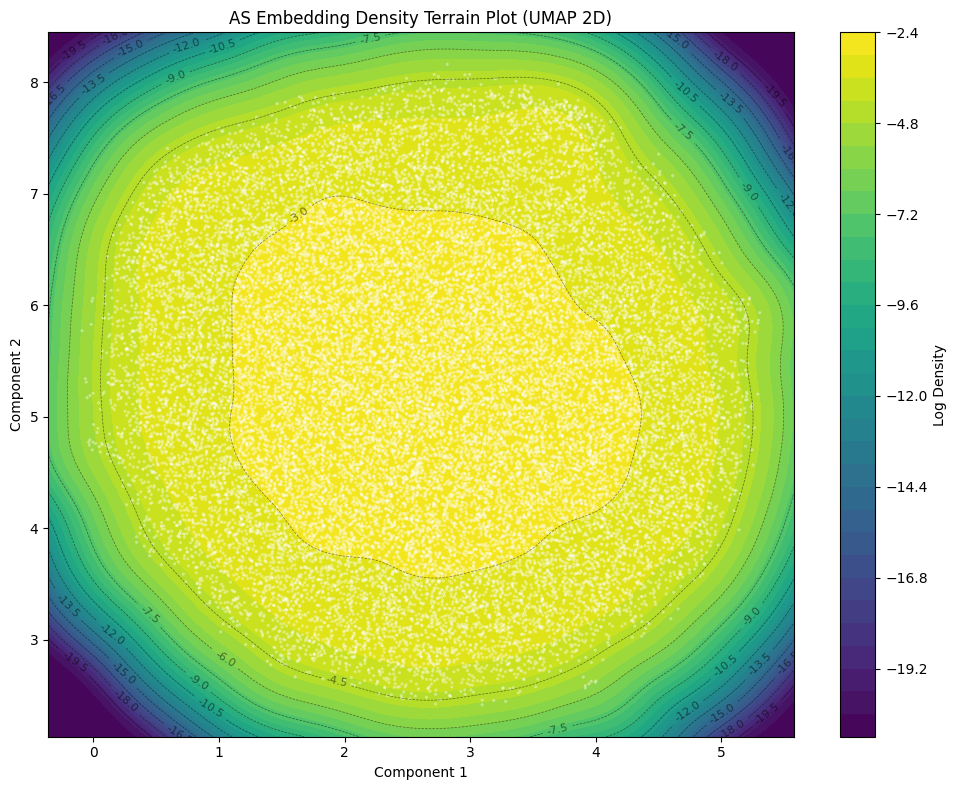

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

# 如果你想用 UMAP，请先: pip install umap-learn
USE_UMAP = True
if USE_UMAP:
    import umap

# =========================
# 1. 读入 embedding 数据
# =========================

# 文件路径
file_path = "/mlx_devbox/users/liurundong.991/playground/embed/output/as_static_embedding_1129-map-mfr-without-feat.txt"   

# 读取：假设是逗号分隔，有表头
df = pd.read_csv(file_path)

# 第一列是 ASN，其余列为 embedding
asn = df.iloc[:, 0].values           # ASN 编号
embeddings = df.iloc[:, 1:].values   # shape: (n_AS, dim)

print("Loaded embeddings:", embeddings.shape)

# =========================
# 2. 降维到 2D (PCA 或 UMAP)
# =========================

if USE_UMAP:
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    embedding_2d = reducer.fit_transform(embeddings)
    method_name = "UMAP"
else:
    pca = PCA(n_components=2, random_state=42)
    embedding_2d = pca.fit_transform(embeddings)
    method_name = "PCA"

x = embedding_2d[:, 0]
y = embedding_2d[:, 1]

print(f"{method_name} 2D embedding shape:", embedding_2d.shape)

# =========================
# 3. KDE 密度估计
# =========================

# 用二维高斯 KDE 估计密度
values = np.vstack([x, y])
kde = gaussian_kde(values)

# 在一个规则网格上评估密度，用于画“地形”
# 根据点的范围自适应网格边界
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# 调整 grid_size 和 padding 看清楚整体结构
grid_size = 200
padding = 0.05  # 给边界稍微扩一点

x_range = x_max - x_min
y_range = y_max - y_min

x_grid = np.linspace(x_min - padding * x_range, x_max + padding * x_range, grid_size)
y_grid = np.linspace(y_min - padding * y_range, y_max + padding * y_range, grid_size)

X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)  # Z 为每个网格点的估计密度

# 可以对 Z 做 log/归一化以增强对比
Z_log = np.log(Z + 1e-9)  # 防止 log(0)

# =========================
# 4. 绘图：地形图 + 等高线 + 散点
# =========================

plt.figure(figsize=(10, 8))

# 背景密度热力图：类似地形底色
# cmap 可以换成 "viridis", "plasma", "inferno", "terrain" 等
contourf = plt.contourf(
    X, Y, Z_log,
    levels=30,           # 等高层数越多越细腻
    cmap="viridis"       # 你也可以尝试 "terrain"
)

# 等高线
contour = plt.contour(
    X, Y, Z_log,
    levels=15,
    colors="k",
    linewidths=0.5,
    alpha=0.5
)

plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

# 叠加散点（每个 AS 一个点，透明度高一点）
plt.scatter(
    x, y,
    s=5,
    c="white",
    alpha=0.4,
    edgecolors="none"
)

plt.title(f"AS Embedding Density Terrain Plot ({method_name} 2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# 颜色条显示密度（log 密度值）
cbar = plt.colorbar(contourf)
cbar.set_label("Log Density")

plt.tight_layout()
plt.show()

In [5]:
!pip install umap-learn


Looking in indexes: https://bytedpypi.byted.org/simple/
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 165.9 MB/s eta 0:00:00
  Using cached https://bytedpypi.byted.org/packages/pynndescent/pynndescent-0.5.13-py3-none-any.whl (56 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 205.2 MB/s eta 0:00:0000:01


## 可视化2

In [10]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. 载入 feature.csv 和 embedding
# -----------------------------
feature_path = r"/mlx_devbox/users/liurundong.991/playground/embed/node_features.csv"
embedding_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/output/as_contextual_embedding_feat_without-nsp.txt'''


from Dataset import ASEmbeddingLoader  # 修改为你真实的 import
loader = ASEmbeddingLoader(embedding_path, device="cpu")

# 读入特征文件
df_feat = pd.read_csv(feature_path)


# 只保留在 embedding 中也存在的 ASN
df_feat = df_feat[df_feat["ASN"].apply(lambda x: x in loader)].copy()

# 去掉 AS_hegemony 缺失的行（构造标签需要）
df_feat = df_feat.dropna(subset=["AS_hegemony"]).copy()

print("Number of ASes with both features and embedding:", len(df_feat))

Number of ASes with both features and embedding: 24129


In [11]:
# -----------------------------
# 2. 基于 AS_hegemony 构造 Routing Role 标签
# -----------------------------
df_role = df_feat[["ASN", "AS_hegemony"]].copy()

# 按 hegemony 降序
df_role = df_role.sort_values("AS_hegemony", ascending=False).reset_index(drop=True)

# H0: Top-15 by AS_hegemony
top_k = 15
df_role["role"] = "N0"   # 默认先设为 Normal
df_role.loc[:top_k-1, "role"] = "H0"

# S0: 后 80% 分位数以下
p80 = np.percentile(df_role["AS_hegemony"], 20)  # “后 80%” 相当于 bottom 20% 分位
df_role.loc[df_role["AS_hegemony"] <= p80, "role"] = "S0"

# 合并回主表
df_feat = df_feat.merge(df_role[["ASN", "role"]], on="ASN", how="left")

print(df_feat["role"].value_counts())

role
N0    19261
S0     4853
H0       15
Name: count, dtype: int64


In [12]:
# -----------------------------
# 3. 为每一类收集 embedding
# -----------------------------
roles = ["H0", "N0", "S0"]
max_per_class = 800  # 每类最多抽 800 个，可根据硬件情况调整

role_embeddings = {}  # dict: role -> (N_role, D) numpy array

for r in roles:
    df_r = df_feat[df_feat["role"] == r]
    if len(df_r) == 0:
        print(f"Warning: no AS for role {r}")
        continue
    
    # 随机下采样（如果样本太多）
    df_r_sample = df_r.sample(
        n=min(len(df_r), max_per_class),
        random_state=42
    )

    # 取 ASN 列表
    asn_list = df_r_sample["ASN"].tolist()
    # 拿到 batch embedding (N, D)
    emb_tensor = loader.get_batch(asn_list).cpu()
    role_embeddings[r] = emb_tensor.numpy()

    print(f"Role {r}: {len(asn_list)} ASes, embedding shape: {role_embeddings[r].shape}")

Role H0: 15 ASes, embedding shape: (15, 128)
Role N0: 800 ASes, embedding shape: (800, 128)
Role S0: 800 ASes, embedding shape: (800, 128)


In [13]:
from sklearn.metrics.pairwise import pairwise_distances

def compute_pairwise_distances(X, Y=None, metric="cosine", sample_size=2000, random_state=42):
    """
    如果 X or Y 样本过大，随机抽样以控制 O(N^2) 复杂度。
    返回：距离矩阵 (n_x', n_y') 或 (n_x', n_x')，类型为 numpy array。
    """
    rng = np.random.default_rng(random_state)
    
    if X.shape[0] > sample_size:
        idx_x = rng.choice(X.shape[0], size=sample_size, replace=False)
        X = X[idx_x]
    if Y is not None and Y.shape[0] > sample_size:
        idx_y = rng.choice(Y.shape[0], size=sample_size, replace=False)
        Y = Y[idx_y]
    
    D = pairwise_distances(X, Y, metric=metric)
    return D

In [14]:
# -----------------------------
# 4. 计算类内/类间距离矩阵
# -----------------------------
metrics = ["cosine", "euclidean"]  # 你可以只选其一

distance_results = {}  # metric -> 结果

for metric in metrics:
    dist_mat = np.zeros((len(roles), len(roles)))
    dist_distributions = {}  # (r1, r2) -> 1D array of distances (flatten)

    for i, ri in enumerate(roles):
        for j, rj in enumerate(roles):
            Xi = role_embeddings.get(ri, None)
            Xj = role_embeddings.get(rj, None)
            if Xi is None or Xj is None:
                dist_mat[i, j] = np.nan
                continue
            
            # 同类用 Xi vs Xi, 异类用 Xi vs Xj
            if ri == rj:
                D = compute_pairwise_distances(Xi, metric=metric)
                # 去掉对角线（自身与自身的距离为 0）
                triu_indices = np.triu_indices_from(D, k=1)
                dvals = D[triu_indices]
            else:
                D = compute_pairwise_distances(Xi, Xj, metric=metric)
                dvals = D.ravel()
            
            dist_mat[i, j] = np.nanmean(dvals)
            dist_distributions[(ri, rj)] = dvals
    
    distance_results[metric] = {
        "matrix": dist_mat,
        "distributions": dist_distributions
    }

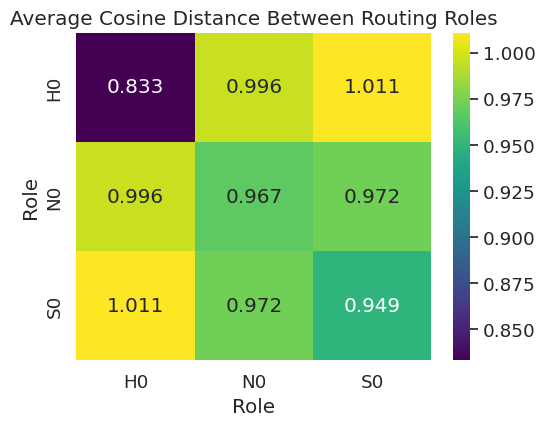

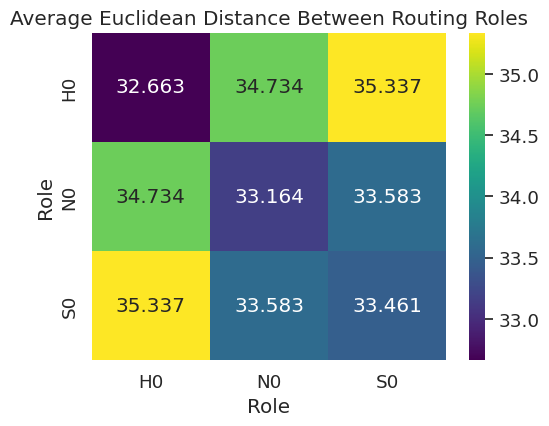

In [15]:
# -----------------------------
# 5. 可视化：平均距离热力图
# -----------------------------
sns.set(style="whitegrid", font_scale=1.2)

for metric in metrics:
    res = distance_results[metric]
    mat = res["matrix"]

    plt.figure(figsize=(5.5, 4.5))
    ax = sns.heatmap(
        mat,
        annot=True,
        fmt=".3f",
        xticklabels=roles,
        yticklabels=roles,
        cmap="viridis"
    )
    ax.set_title(f"Average {metric.capitalize()} Distance Between Routing Roles")
    ax.set_xlabel("Role")
    ax.set_ylabel("Role")
    plt.tight_layout()
    plt.show()

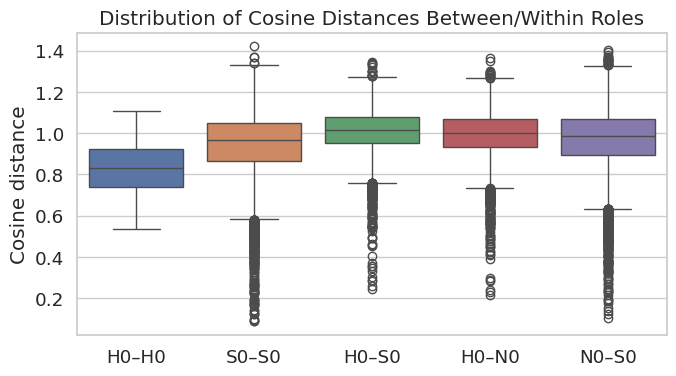

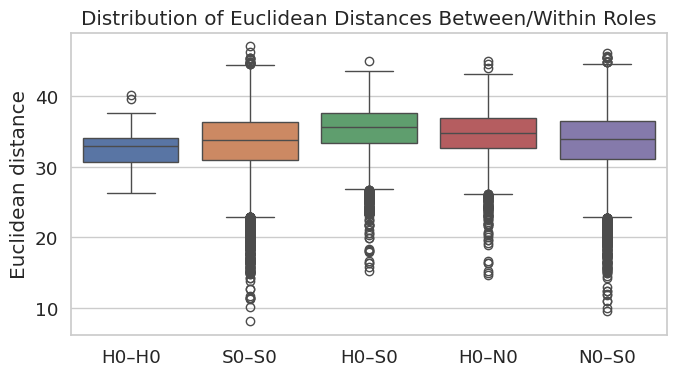

In [16]:
# -----------------------------
# 6. 可视化：距离分布箱线图
# -----------------------------
pairs_to_plot = [
    ("H0", "H0"),
    ("S0", "S0"),
    ("H0", "S0"),
    ("H0", "N0"),
    ("N0", "S0"),
]

for metric in metrics:
    res = distance_results[metric]
    dist_distributions = res["distributions"]

    data_for_box = []
    labels = []

    for (r1, r2) in pairs_to_plot:
        dvals = dist_distributions.get((r1, r2), None)
        if dvals is None or len(dvals) == 0:
            continue
        
        # 若分布太大，可随机再抽样一部分以减少绘图开销
        if len(dvals) > 20000:
            dvals = np.random.choice(dvals, size=20000, replace=False)
        
        data_for_box.append(dvals)
        labels.append(f"{r1}–{r2}")

    if len(data_for_box) == 0:
        continue

    plt.figure(figsize=(7, 4))
    sns.boxplot(data=data_for_box)
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.ylabel(f"{metric.capitalize()} distance")
    plt.title(f"Distribution of {metric.capitalize()} Distances Between/Within Roles")
    plt.tight_layout()
    plt.show()

In [17]:
from scipy.stats import mannwhitneyu, ks_2samp
import pandas as pd
import numpy as np

# -----------------------------
# 7. 统计检验 + 效果量
# -----------------------------

# 要比较的距离分布对：（role_pair_A, role_pair_B, 描述）
# 这里的 role_pair 是 distance_results 中的 key: (r1, r2)
comparisons = [
    (("H0", "H0"), ("H0", "S0"), "H0-H0 vs H0-S0"),
    (("S0", "S0"), ("H0", "S0"), "S0-S0 vs H0-S0"),
    (("H0", "H0"), ("S0", "S0"), "H0-H0 vs S0-S0"),
    (("H0", "H0"), ("N0", "N0"), "H0-H0 vs N0-N0"),
    (("N0", "N0"), ("S0", "S0"), "N0-N0 vs S0-S0"),
]

def cohens_d(x, y):
    # x, y: 1D arrays
    x = np.asarray(x)
    y = np.asarray(y)
    nx = len(x)
    ny = len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # pooled std
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    pooled_var = ((nx - 1) * var_x + (ny - 1) * var_y) / (nx + ny - 2)
    return (mean_x - mean_y) / np.sqrt(pooled_var)

# 用于保存结果的 DataFrame 列表，按 metric 组织
stats_tables = {}

for metric in distance_results.keys():
    dist_distributions = distance_results[metric]["distributions"]

    rows = []
    for (pairA, pairB, desc) in comparisons:
        dA = dist_distributions.get(pairA, None)
        dB = dist_distributions.get(pairB, None)

        if dA is None or dB is None or len(dA) == 0 or len(dB) == 0:
            continue

        # 为了计算效率，必要时再做一次下采样
        max_n = 30000
        if len(dA) > max_n:
            dA = np.random.choice(dA, size=max_n, replace=False)
        if len(dB) > max_n:
            dB = np.random.choice(dB, size=max_n, replace=False)

        # 去除 NaN 和 inf
        dA = dA[np.isfinite(dA)]
        dB = dB[np.isfinite(dB)]
        if len(dA) < 10 or len(dB) < 10:
            continue

        # Mann–Whitney U test（非参数：检验分布是否有显著差异，尤其中位数差）
        u_stat, p_mw = mannwhitneyu(dA, dB, alternative="two-sided")

        # Kolmogorov–Smirnov test（检验分布整体是否相同）
        ks_stat, p_ks = ks_2samp(dA, dB, alternative="two-sided")

        # 效果量：Cohen's d（基于均值差和 pooled std）
        d_effect = cohens_d(dA, dB)

        row = {
            "comparison": desc,
            "pair_A": f"{pairA[0]}-{pairA[1]}",
            "pair_B": f"{pairB[0]}-{pairB[1]}",
            "n_A": len(dA),
            "n_B": len(dB),
            "mean_A": np.mean(dA),
            "mean_B": np.mean(dB),
            "median_A": np.median(dA),
            "median_B": np.median(dB),
            "u_stat": u_stat,
            "p_mannwhitney": p_mw,
            "ks_stat": ks_stat,
            "p_ks": p_ks,
            "cohens_d": d_effect,
        }
        rows.append(row)

    if rows:
        stats_tables[metric] = pd.DataFrame(rows)
        print(f"\n=== Statistical results for metric: {metric} ===")
        print(stats_tables[metric].to_string(index=False))


=== Statistical results for metric: cosine ===
    comparison pair_A pair_B   n_A   n_B   mean_A   mean_B  median_A  median_B      u_stat  p_mannwhitney  ks_stat         p_ks  cohens_d
H0-H0 vs H0-S0  H0-H0  H0-S0   105 12000 0.833170 1.010827  0.830946  1.012748    164480.0   5.797709e-39 0.598893 3.486061e-36 -1.738823
S0-S0 vs H0-S0  S0-S0  H0-S0 30000 12000 0.949145 1.010827  0.965971  1.012748 135186994.5   0.000000e+00 0.215400 0.000000e+00 -0.450172
H0-H0 vs S0-S0  H0-H0  S0-S0   105 30000 0.833170 0.949414  0.830946  0.966349    820539.5   2.123471e-17 0.391876 4.866218e-15 -0.784672
H0-H0 vs N0-N0  H0-H0  N0-N0   105 30000 0.833170 0.967030  0.830946  0.979997    714026.0   3.492863e-22 0.434010 1.686587e-18 -0.955096
N0-N0 vs S0-S0  N0-N0  S0-S0 30000 30000 0.966838 0.947741  0.979538  0.965773 480604964.5   3.489496e-47 0.050933 2.936299e-34  0.131153

=== Statistical results for metric: euclidean ===
    comparison pair_A pair_B   n_A   n_B    mean_A    mean_B  median_A  m

In [18]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", font_scale=1.2)

roles = ["H0", "N0", "S0"]

# 如果之前已经定义就不需要再定义
def compute_pairwise_distances(X, Y=None, metric="cosine", sample_size=2000, random_state=42):
    rng = np.random.default_rng(random_state)
    
    if X.shape[0] > sample_size:
        idx_x = rng.choice(X.shape[0], size=sample_size, replace=False)
        X = X[idx_x]
    if Y is not None and Y.shape[0] > sample_size:
        idx_y = rng.choice(Y.shape[0], size=sample_size, replace=False)
        Y = Y[idx_y]
    
    D = pairwise_distances(X, Y, metric=metric)
    return D

def build_role_embeddings(df_with_role, loader, roles, max_per_class=800, random_state=42):
    """
    输入：包含列 ["ASN", "role"] 的 DataFrame
    输出：role -> embedding ndarray
    """
    rng = np.random.default_rng(random_state)
    role_emb = {}
    for r in roles:
        df_r = df_with_role[df_with_role["role"] == r]
        if len(df_r) == 0:
            print(f"[build_role_embeddings] Warning: no AS for role {r}")
            continue
        
        if len(df_r) > max_per_class:
            df_r = df_r.sample(n=max_per_class, random_state=random_state)
        
        asn_list = df_r["ASN"].tolist()
        emb_tensor = loader.get_batch(asn_list).cpu()
        role_emb[r] = emb_tensor.numpy()
        print(f"[build_role_embeddings] Role {r}: {len(asn_list)} ASes, shape: {role_emb[r].shape}")
    return role_emb

def compute_role_distance_matrix(role_emb, roles, metric="cosine", sample_size=2000, random_state=42):
    """
    返回：avg_dist_matrix, dist_distributions
    - avg_dist_matrix: (len(roles), len(roles))，类间平均距离
    - dist_distributions: dict[(r1, r2)] -> 1D array of pairwise distances
    """
    mat = np.zeros((len(roles), len(roles)))
    dist_distributions = {}
    
    for i, ri in enumerate(roles):
        for j, rj in enumerate(roles):
            Xi = role_emb.get(ri, None)
            Xj = role_emb.get(rj, None)
            if Xi is None or Xj is None:
                mat[i, j] = np.nan
                continue
            
            if ri == rj:
                D = compute_pairwise_distances(Xi, metric=metric,
                                               sample_size=sample_size,
                                               random_state=random_state)
                triu_indices = np.triu_indices_from(D, k=1)
                dvals = D[triu_indices]
            else:
                D = compute_pairwise_distances(Xi, Xj, metric=metric,
                                               sample_size=sample_size,
                                               random_state=random_state)
                dvals = D.ravel()
            
            mat[i, j] = np.nanmean(dvals)
            dist_distributions[(ri, rj)] = dvals
    
    return mat, dist_distributions

In [19]:
# -----------------------------
# 1) 构造随机标签基线
# -----------------------------

df_base = df_feat[["ASN", "role"]].copy()  # 真实标签

# 统计每个角色真实的样本数
role_counts = df_base["role"].value_counts().to_dict()
print("True role counts:", role_counts)

# 随机打乱 ASN 顺序
rng = np.random.default_rng(12345)
shuffled_asn = df_base["ASN"].sample(frac=1.0, random_state=12345).tolist()

# 按照原 role_counts 把打乱后的 ASN 划分成 H0/N0/S0
random_role_list = []
start = 0
for r in roles:
    cnt = role_counts.get(r, 0)
    end = start + cnt
    subset_asn = shuffled_asn[start:end]
    random_role_list.extend([(asn, r) for asn in subset_asn])
    start = end

# 构造随机标签 DataFrame
df_random = pd.DataFrame(random_role_list, columns=["ASN", "role"])
print(df_random["role"].value_counts())

True role counts: {'N0': 19261, 'S0': 4853, 'H0': 15}
role
N0    19261
S0     4853
H0       15
Name: count, dtype: int64



=== Metric: cosine ===
[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)


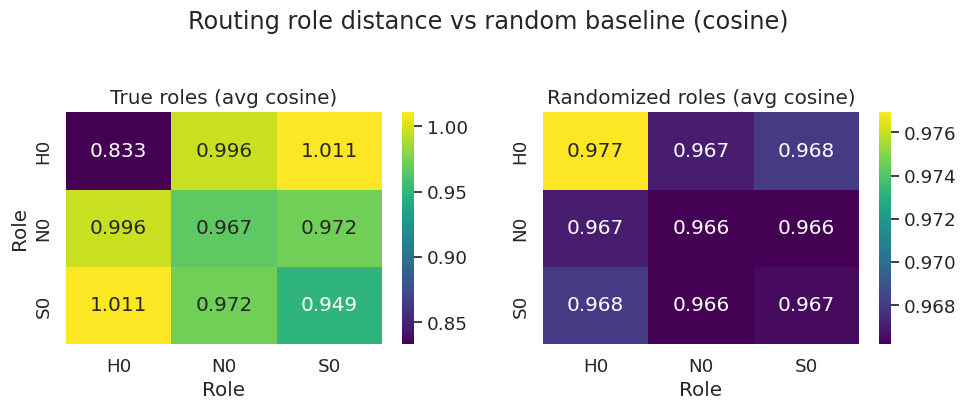


=== Metric: euclidean ===
[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)


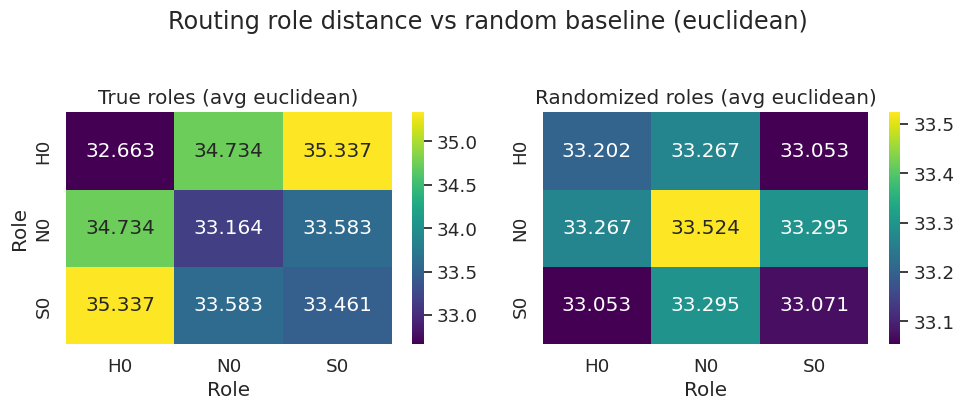

In [22]:
metrics = ["cosine", "euclidean"]  # 你可以只用 cosine，也可以两种都看
max_per_class = 800
sample_size = 2000

for metric in metrics:
    print(f"\n=== Metric: {metric} ===")
    
    # 真实标签
    true_role_emb = build_role_embeddings(df_base, loader, roles,
                                          max_per_class=max_per_class,
                                          random_state=42)
    true_mat, true_dist = compute_role_distance_matrix(
        true_role_emb, roles, metric=metric,
        sample_size=sample_size, random_state=42
    )
    
    # 随机标签
    random_role_emb = build_role_embeddings(df_random, loader, roles,
                                            max_per_class=max_per_class,
                                            random_state=42)
    rand_mat, rand_dist = compute_role_distance_matrix(
        random_role_emb, roles, metric=metric,
        sample_size=sample_size, random_state=42
    )
    
    # -----------------------------
    # 可视化：真实标签 vs 随机标签 距离矩阵对比
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.heatmap(true_mat, annot=True, fmt=".3f",
                xticklabels=roles, yticklabels=roles,
                cmap="viridis", ax=axes[0])
    axes[0].set_title(f"True roles (avg {metric})")
    axes[0].set_xlabel("Role")
    axes[0].set_ylabel("Role")
    
    sns.heatmap(rand_mat, annot=True, fmt=".3f",
                xticklabels=roles, yticklabels=roles,
                cmap="viridis", ax=axes[1])
    axes[1].set_title(f"Randomized roles (avg {metric})")
    axes[1].set_xlabel("Role")
    axes[1].set_ylabel("")
    
    fig.suptitle(f"Routing role distance vs random baseline ({metric})", y=1.03)
    plt.tight_layout()
    plt.show()

In [23]:
from scipy.stats import mannwhitneyu

metric = "cosine"  # 选一个你最关心的度量

# 真实标签的分布
true_role_emb = build_role_embeddings(df_base, loader, roles,
                                      max_per_class=max_per_class,
                                      random_state=42)
true_mat, true_dist = compute_role_distance_matrix(
    true_role_emb, roles, metric=metric,
    sample_size=sample_size, random_state=42
)

# 随机标签的分布
random_role_emb = build_role_embeddings(df_random, loader, roles,
                                        max_per_class=max_per_class,
                                        random_state=42)
rand_mat, rand_dist = compute_role_distance_matrix(
    random_role_emb, roles, metric=metric,
    sample_size=sample_size, random_state=42
)

pair = ("H0", "S0")
d_true = true_dist[pair]
d_rand = rand_dist[pair]

# 为了检验速度，可以再采样
max_n = 20000
if len(d_true) > max_n:
    d_true = np.random.choice(d_true, size=max_n, replace=False)
if len(d_rand) > max_n:
    d_rand = np.random.choice(d_rand, size=max_n, replace=False)

stat, pval = mannwhitneyu(d_true, d_rand, alternative="two-sided")
print(f"Mann–Whitney U test for {pair} ({metric}): U={stat:.2e}, p={pval:.2e}")

[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role H0: 15 ASes, shape: (15, 128)
[build_role_embeddings] Role N0: 800 ASes, shape: (800, 128)
[build_role_embeddings] Role S0: 800 ASes, shape: (800, 128)
Mann–Whitney U test for ('H0', 'S0') (cosine): U=8.47e+07, p=1.68e-124


## 可视化3

In [106]:
def plot_as_embedding(
    embed_path: str,
    feature_path: str,
    category_cols: list,
    method: str = "umap",
    top_hegemony_ratio: float = 0.2,
    random_state: int = 42,
    balance_classes: bool = True,
):
    """
    可视化 AS embedding：
    - 坐标：embedding 降维到 2D (PCA / UMAP / t-SNE)
    - 颜色：category_cols 中最大值对应的列（类别名取列名最后一个 '_' 之后部分）
    - 点大小：AS_rank_total
    - 透明度：AS_hegemony（越大越不透明）
    - 仅保留 AS_hegemony 排名前 top_hegemony_ratio 的 AS
    - 可选：对每个类别做下采样，使类别数量均衡

    Parameters
    ----------
    embed_path : str
        embedding 文件路径（可由 ASEmbeddingLoader 读取）
    feature_path : str
        feature.csv 路径，必须包含列 'ASN', 'AS_rank_total', 'AS_hegemony'，以及 category_cols
    category_cols : list[str]
        用于分类上色的列名列表（如 ["AS_rank_continent_Africa", ...]）。
        每个 AS 的类别取这几列中数值最大的那一列。
    method : {"pca", "umap", "tsne"}, optional
        降维方法，默认 "umap"。
    top_hegemony_ratio : float, optional
        按 AS_hegemony 保留的前比例，默认前 20%（0.2）。
    output_path : str or None, optional
        图像输出路径；若为 None，则默认保存为
        "as_embedding_{method}_top{ratio}_hegemony_balanced.png" 或 unbalanced 版本。
    random_state : int, optional
        随机种子，用于 UMAP/TSNE 以及类别下采样的可重复性。
    balance_classes : bool, optional
        是否对每个类别进行下采样，使各类别样本数相等（取最小类别数）。
        默认 True。

    Returns
    -------
    df_plot : pandas.DataFrame
        最终用于绘图的数据（附带降维结果和类别标签）。
    """

    rng = np.random.default_rng(random_state)

    # --------------------
    # 1. 加载数据
    # --------------------
    loader = ASEmbeddingLoader(embed_path, device="cpu")
    df_feat = pd.read_csv(feature_path)

    # 必要列检查
    if "ASN" not in df_feat.columns:
        raise ValueError("feature.csv 中必须包含 'ASN' 列")

    for col in ["AS_rank_total", "AS_hegemony"]:
        if col not in df_feat.columns:
            raise ValueError(f"feature.csv 中缺少必要列: {col}")

    for col in category_cols:
        if col not in df_feat.columns:
            raise ValueError(f"feature.csv 中缺少分类列: {col}")

    # --------------------
    # 2. 与 embedding 对齐 + 丢弃缺失值
    # --------------------
    asns_in_embed = [asn for asn in df_feat["ASN"].tolist() if asn in loader]
    df_feat = df_feat[df_feat["ASN"].isin(asns_in_embed)].copy()

    required_cols = ["AS_rank_total", "AS_hegemony"] + category_cols
    df_feat = df_feat.dropna(subset=required_cols)
    df_feat.reset_index(drop=True, inplace=True)

    if df_feat.empty:
        raise ValueError("对齐并丢弃缺失值后，数据为空，请检查输入。")

    # --------------------
    # 3. 按 AS_hegemony 过滤前 top_hegemony_ratio
    # --------------------
    hegemony = df_feat["AS_hegemony"].values
    threshold = np.quantile(hegemony, 1.0 - top_hegemony_ratio)
    df_top = df_feat[df_feat["AS_hegemony"] >= threshold].copy()
    df_top.reset_index(drop=True, inplace=True)

    if df_top.empty:
        raise ValueError("AS_hegemony 过滤后为空，请调整 top_hegemony_ratio 或检查数据。")

    print(f"[INFO] 过滤后，用于分类和采样的 AS 数量: {len(df_top)}"
          f" (top {top_hegemony_ratio*100:.1f}% hegemony)")

    # --------------------
    # 4. 计算分类标签（category assignment）
    #    取 category_cols 中最大值对应的列
    # --------------------
    cat_values = df_top[category_cols].values  # shape: (N, C)
    cat_idx = np.argmax(cat_values, axis=1)
    cat_labels_full = [category_cols[i] for i in cat_idx]

    def short_name(col_name: str) -> str:
        return col_name.split("_")[-1]

    cat_labels_short = [short_name(c) for c in cat_labels_full]
    df_top["category_full"] = cat_labels_full
    df_top["category"] = cat_labels_short

    # --------------------
    # 5. 类别均衡采样（下采样到最小类别数）
    # --------------------
    if balance_classes:
        counts = df_top["category"].value_counts()
        min_count = counts.min()
        print("[INFO] 类别样本数：")
        print(counts)
        print(f"[INFO] 按最小类别数 {min_count} 进行均衡下采样")

        dfs_balanced = []
        for cat, cnt in counts.items():
            df_cat = df_top[df_top["category"] == cat]
            if cnt > min_count:
                # 随机采样 min_count 行
                sampled_idx = rng.choice(df_cat.index.values, size=min_count, replace=False)
                df_cat_balanced = df_cat.loc[sampled_idx]
            else:
                df_cat_balanced = df_cat
            dfs_balanced.append(df_cat_balanced)

        df_plot = pd.concat(dfs_balanced, axis=0)
        df_plot = df_plot.sample(frac=1.0, random_state=random_state).reset_index(drop=True)  # 打乱
    else:
        df_plot = df_top.copy()

    print(f"[INFO] 均衡采样后用于绘图的 AS 数量: {len(df_plot)}，"
          f"不同类别样本数：\n{df_plot['category'].value_counts()}")

    # --------------------
    # 6. 提取 embedding 向量（对应 df_plot 中的 ASN）
    # --------------------
    asns_plot = df_plot["ASN"].tolist()
    emb_list = []
    for asn in asns_plot:
        emb = loader.get_embedding(asn)
        if hasattr(emb, "detach"):
            emb = emb.detach().cpu().numpy()
        emb_list.append(emb)
    X_embed = np.vstack(emb_list)
    print("[INFO] Embedding shape:", X_embed.shape)

    # --------------------
    # 7. 降维到 2D
    # --------------------
    method = method.lower()
    if method == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
        X_2d = reducer.fit_transform(X_embed)
    elif method == "umap":
        if umap is None:
            raise ImportError("umap-learn 未安装，请安装后再使用 UMAP 或改用 PCA/t-SNE。")
        reducer = umap.UMAP(
            n_neighbors=30,
            min_dist=0.1,
            n_components=2,
            metric="cosine",
            random_state=random_state,
        )
        X_2d = reducer.fit_transform(X_embed)
    elif method == "tsne":
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate="auto",
            init="random",
            random_state=random_state,
            n_iter=1000,
            verbose=1,
        )
        X_2d = tsne.fit_transform(X_embed)
    else:
        raise ValueError("method 必须是 'pca', 'umap', 或 'tsne' 之一。")

    df_plot["x"] = X_2d[:, 0]
    df_plot["y"] = X_2d[:, 1]

    # --------------------
    # 8. 点大小：AS_rank_total 归一化
    # --------------------
    size_raw = df_plot["AS_rank_total"].values.reshape(-1, 1)
    size_scaled = MinMaxScaler(feature_range=(20, 300)).fit_transform(size_raw).flatten()

    # --------------------
    # 9. 透明度：AS_hegemony 归一化（越大越不透明）
    # --------------------
    heg_raw = df_plot["AS_hegemony"].values.reshape(-1, 1)
    alpha_scaled = MinMaxScaler(feature_range=(0.9, 1.0)).fit_transform(heg_raw).flatten()

    # --------------------
    # 10. 颜色：根据 category
    # --------------------
    unique_cats = sorted(df_plot["category"].unique())
    base_colors = [
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a",
        "#66a61e", "#e6ab02", "#a6761d", "#666666",
        "#1f78b4", "#b2df8a", "#fb9a99", "#fdbf6f",
    ]
    colors = [base_colors[i % len(base_colors)] for i in range(len(unique_cats))]
    cmap = ListedColormap(colors)
    cat_to_idx = {c: i for i, c in enumerate(unique_cats)}
    color_indices = [cat_to_idx[c] for c in df_plot["category"]]

    # --------------------
    # 11. 绘图
    # --------------------
    plt.figure(figsize=(10, 8))

    for x, y, c_idx, sz, a in zip(
        df_plot["x"], df_plot["y"], color_indices, size_scaled, alpha_scaled
    ):
        plt.scatter(
            x,
            y,
            c=[cmap(c_idx)],
            s=sz,
            alpha=float(a),
            edgecolors="none",
        )

    # 图例（类别）
    handles = []
    labels = []
    for cat in unique_cats:
        handles.append(
            plt.Line2D(
                [], [], marker="o", color=colors[cat_to_idx[cat]],
                linestyle="None", markersize=8
            )
        )
        labels.append(cat)

    legend1 = plt.legend(
        handles,
        labels,
        title="Category",
        loc="upper right",
        frameon=True,
    )
    plt.gca().add_artist(legend1)

    bal_tag = "balanced" if balance_classes else "unbalanced"
    title = f"AS Embedding ({method.upper()}), Top {top_hegemony_ratio*100:.0f}% Hegemony, {bal_tag}"
    plt.title(title)
    plt.xlabel(f"{method.upper()}-1")
    plt.ylabel(f"{method.upper()}-2")
    plt.tight_layout()

    # if output_path is None:
    #     output_path = f"as_embedding_{method}_top{int(top_hegemony_ratio*100)}_hegemony_{bal_tag}.png"
    # plt.savefig(output_path, dpi=300)
    # print(f"[INFO] Figure saved to: {os.path.abspath(output_path)}")

    plt.show()

    return df_plot

[INFO] 过滤后，用于分类和采样的 AS 数量: 15467 (top 100.0% hegemony)
[INFO] 均衡采样后用于绘图的 AS 数量: 15467，不同类别样本数：
category
Open           14818
Selective        550
Restrictive       99
Name: count, dtype: int64
[INFO] Embedding shape: (15467, 128)


/home/tiger/miniforge3/envs/beam/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


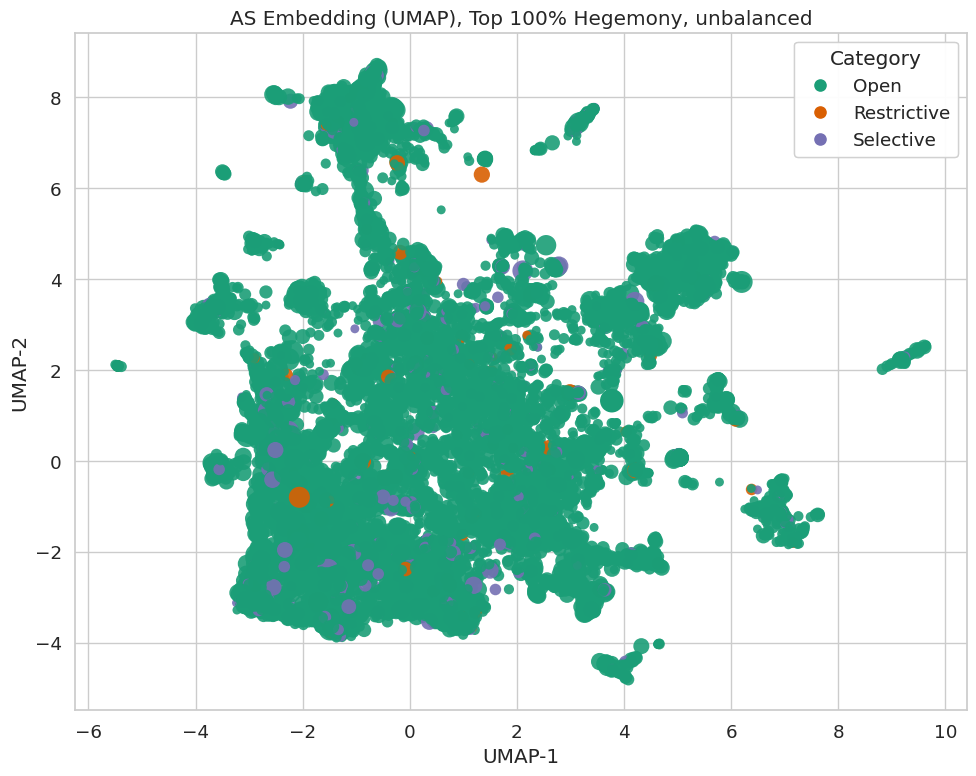

In [112]:
# category_cols = [
#         "peeringDB_info_ratio_Balanced",
#         "peeringDB_info_ratio_Heavy Inbound",
#         "peeringDB_info_ratio_Heavy Outbound",
#         "peeringDB_info_ratio_Mostly Inbound",
#         "peeringDB_info_ratio_Mostly Outbound",
# ]


category_cols = [
        "peeringDB_policy_general_Open",
        "peeringDB_policy_general_Restrictive",
        "peeringDB_policy_general_Selective",
    ]

# category_cols = [
#         "peeringDB_info_ratio_Balanced",
#         "peeringDB_info_ratio_Heavy Inbound",
#         "peeringDB_info_ratio_Heavy Outbound",
#         "peeringDB_info_ratio_Mostly Inbound",
#         "peeringDB_info_ratio_Mostly Outbound",
# ]



feature_path = r"/mlx_devbox/users/liurundong.991/playground/embed/node_features.csv"
embed_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/output/as_contextual_embedding_1128-only-map-without-feat.txt'''
# embed_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/bgp2vec/bgp2vec_asn_embeddings.txt'''


df_plot = plot_as_embedding(
    embed_path=embed_path,
    feature_path=feature_path,
    category_cols=category_cols,
    method="umap",
    balance_classes = False,
    top_hegemony_ratio = 1
)

## 可视化4

In [103]:
import os
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False



DimMethod = Literal["pca", "umap", "tsne"]


def visualize_as_embedding_clusters(
    embed_path: str,
    feature_path: str,
    dim_method: DimMethod = "umap",
    n_clusters: int = 8,
    size_field: str = "AS_rank_total",
    hegemony_top_ratio: float = 0.2,
    random_state: int = 42,
):
    """
    对 AS embedding 进行降维 + 无监督聚类可视化。

    参数
    ----
    embed_path : str
        embedding 文件路径，用 ASEmbeddingLoader 加载。
    feature_path : str
        包含 ASN 和特征的 CSV 路径。
    dim_method : {"pca", "umap", "tsne"}
        降维方式。
    n_clusters : int
        KMeans 聚类簇数。
    size_field : str
        控制点大小的字段名，例如 "AS_rank_total"。
    hegemony_top_ratio : float
        按 AS_hegemony 过滤的比例，例如 0.2 表示保留前 20%。
        如果为 None 或 <= 0，则不做过滤。
    random_state : int
        随机种子（用于 KMeans / UMAP / t-SNE）。
    out_prefix : str | None
        输出文件名前缀（PNG 和 CSV），如果为 None，则根据 embed_path 自动生成。

    输出
    ----
    - 保存一张 PNG 图：
        {out_prefix}_clusters_{dim_method}.png
    - 保存一个 CSV：
        {out_prefix}_clusters_{dim_method}.csv
      包含：ASN、2D 坐标、聚类标签、部分特征。
    """

    # -------------------------
    # 1. 加载数据
    # -------------------------
    loader = ASEmbeddingLoader(embed_path, device="cpu")
    df_feat = pd.read_csv(feature_path)

    if "ASN" not in df_feat.columns:
        raise ValueError("feature.csv 中必须包含 'ASN' 列")

    # 与 embedding 对齐：只保留在 embedding 中存在的 ASN
    asns_in_embed = [asn for asn in df_feat["ASN"].tolist() if asn in loader]
    df_feat = df_feat[df_feat["ASN"].isin(asns_in_embed)].copy()
    df_feat.reset_index(drop=True, inplace=True)

    if df_feat.empty:
        raise ValueError("在 feature.csv 中没有找到任何同时存在于 embedding 的 ASN")

    # -------------------------
    # 2. 清洗关键字段 & 按 AS_hegemony 过滤
    # -------------------------
    # 至少保证有 hegemony 和 size_field
    required_cols = ["AS_hegemony", size_field]
    missing_req = [c for c in required_cols if c not in df_feat.columns]
    if missing_req:
        raise ValueError(f"feature.csv 缺少必要字段: {missing_req}")

    df_feat = df_feat.dropna(subset=required_cols)
    df_feat.reset_index(drop=True, inplace=True)

    if hegemony_top_ratio is not None and hegemony_top_ratio > 0:
        # heg = df_feat["AS_hegemony"].values
        # threshold = np.quantile(heg, 1.0 - hegemony_top_ratio)
        # df_top = df_feat[df_feat["AS_hegemony"] >= threshold].copy()
        # df_top.reset_index(drop=True, inplace=True)
        # print(
        #     f"过滤：AS_hegemony 前 {int(hegemony_top_ratio * 100)}% "
        #     f"AS 数量 = {len(df_top)} / {len(df_feat)}"
        # )

        frac = hegemony_top_ratio
        # 随机抽样 frac 比例，不再按 hegemony 排名
        df_top = df_feat.sample(
            frac=frac,
            random_state=random_state,
        ).copy()
        df_top.reset_index(drop=True, inplace=True)
        print(
            f"随机抽取约 {int(frac * 100)}% AS，"
            f"样本数量 = {len(df_top)} / {len(df_feat)}"
        )



    else:
        df_top = df_feat
        print(f"未按 AS_hegemony 过滤，使用全部 {len(df_top)} 个 AS")

    if df_top.empty:
        raise ValueError("按 AS_hegemony 过滤后没有剩余 AS，请调小 hegemony_top_ratio")

    # -------------------------
    # 3. 提取 embedding 矩阵
    # -------------------------
    asns = df_top["ASN"].tolist()
    emb_list = []
    for asn in asns:
        emb = loader.get_embedding(asn)
        if hasattr(emb, "detach"):  # torch.Tensor
            emb = emb.detach().cpu().numpy()
        emb_list.append(emb)

    X_embed = np.vstack(emb_list)  # (N, d)
    print("Embedding shape:", X_embed.shape)

    # -------------------------
    # 4. 降维到 2D
    # -------------------------
    dim_method = dim_method.lower()
    if dim_method not in {"pca", "umap", "tsne"}:
        raise ValueError("dim_method 必须是 'pca', 'umap' 或 'tsne'")

    if dim_method == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
        X_2d = reducer.fit_transform(X_embed)

    elif dim_method == "umap":
        if not HAS_UMAP:
            raise ImportError("未安装 umap-learn，请先 `pip install umap-learn`")
        reducer = umap.UMAP(
            n_neighbors=30,
            min_dist=0.1,
            n_components=2,
            metric="euclidean",
            random_state=random_state,
        )
        X_2d = reducer.fit_transform(X_embed)

    else:  # tsne
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate="auto",
            init="random",
            random_state=random_state,
            n_iter=1000,
            verbose=1,
        )
        X_2d = tsne.fit_transform(X_embed)

    # -------------------------
    # 5. KMeans 聚类
    # -------------------------
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=random_state,
        n_init="auto",
    )
    cluster_labels = kmeans.fit_predict(X_2d)

    df_top["x_2d"] = X_2d[:, 0]
    df_top["y_2d"] = X_2d[:, 1]
    df_top["cluster"] = cluster_labels

    # -------------------------
    # 6. 点大小：使用 size_field 归一化
    # -------------------------
    size_raw = df_top[size_field].astype(float).values.reshape(-1, 1)
    scaler_size = MinMaxScaler(feature_range=(10, 300))  # 点面积区间
    size_scaled = scaler_size.fit_transform(size_raw).flatten()

    # -------------------------
    # 7. 颜色：按聚类标签
    # -------------------------
    unique_clusters = np.sort(df_top["cluster"].unique())
    n_clu = len(unique_clusters)

    # 使用 matplotlib colormap
    cmap = get_cmap("tab10") if n_clu <= 10 else get_cmap("tab20")
    colors = [cmap(i % cmap.N) for i in unique_clusters]
    clu_to_color = {c: colors[i] for i, c in enumerate(unique_clusters)}
    point_colors = [clu_to_color[c] for c in df_top["cluster"]]

    # -------------------------
    # 8. 绘图
    # -------------------------
    plt.figure(figsize=(10, 8))
    plt.scatter(
        df_top["x_2d"],
        df_top["y_2d"],
        c=point_colors,
        s=size_scaled,
        alpha=0.8,
        edgecolors="none",
    )

    # 聚类图例
    handles = []
    labels = []
    for c in unique_clusters:
        handles.append(
            plt.Line2D(
                [], [], marker="o",
                color=clu_to_color[c],
                linestyle="None",
                markersize=8,
            )
        )
        labels.append(f"Cluster {c}")
    plt.legend(
        handles,
        labels,
        title="Clusters",
        loc="upper right",
        frameon=True,
    )

    plt.xlabel(f"{dim_method.upper()}-1")
    plt.ylabel(f"{dim_method.upper()}-2")
    plt.title(
        f"AS Embedding Clusters ({dim_method.upper()}, "
        f"Top {int(hegemony_top_ratio * 100)}% by AS_hegemony, K={n_clusters})"
    )

    plt.tight_layout()

    # fig_path = f"{out_prefix}_clusters_{dim_method}.png"
    # plt.savefig(fig_path, dpi=300)
    # plt.close()
    # print(f"Figure saved to: {os.path.abspath(fig_path)}")

    # # -------------------------
    # # 9. 保存带聚类结果的 CSV
    # # -------------------------
    # csv_path = f"{out_prefix}_clusters_{dim_method}.csv"
    # df_top.to_csv(csv_path, index=False)
    # print(f"Clustered data saved to: {os.path.abspath(csv_path)}")

    # return df_top, fig_path, csv_path

随机抽取约 10% AS，样本数量 = 2408 / 24082
Embedding shape: (2408, 128)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2408 samples in 0.001s...
[t-SNE] Computed neighbors for 2408 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2408
[t-SNE] Computed conditional probabilities for sample 2000 / 2408
[t-SNE] Computed conditional probabilities for sample 2408 / 2408
[t-SNE] Mean sigma: 8.290689
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.483047
[t-SNE] KL divergence after 1000 iterations: 1.844260


/tmp/ipykernel_1981353/919174353.py:202: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab10") if n_clu <= 10 else get_cmap("tab20")


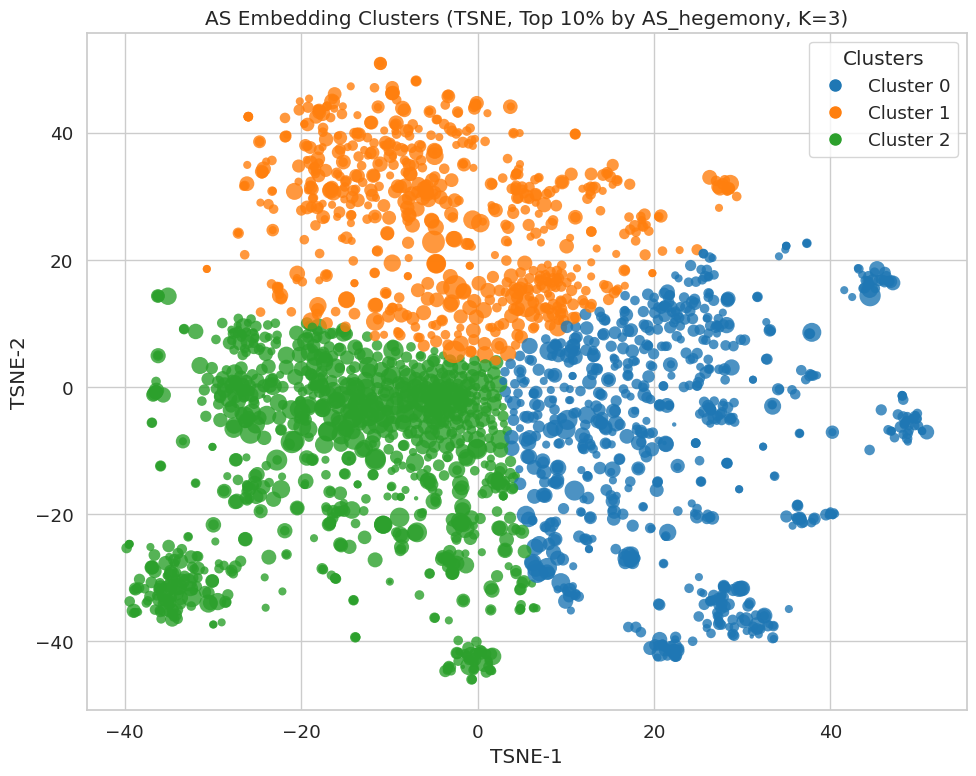

In [109]:
feature_path = r"/mlx_devbox/users/liurundong.991/playground/embed/node_features.csv"
embed_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/output/as_contextual_embedding_1128-only-map-without-feat.txt'''
# embed_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/bgp2vec/bgp2vec_asn_embeddings.txt'''


visualize_as_embedding_clusters(
    embed_path=embed_path,
    feature_path=feature_path,
    dim_method="tsne",          # "pca" / "tsne" 也可以
    n_clusters=3,
    size_field="AS_rank_total", # 可换 "AS_rank_customer" 等
    hegemony_top_ratio=0.1,
)

## 可视化5

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from Dataset import ASEmbeddingLoader

# -----------------------
# 1.1 载入 embedding
# -----------------------
# 假设已有 ASEmbeddingLoader
# from your_module import ASEmbeddingLoader

feature_path = r"/mlx_devbox/users/liurundong.991/playground/embed/node_features.csv"
embed_path = r'''/mlx_devbox/users/liurundong.991/playground/embed/output/as_contextual_embedding_1128-only-map-without-feat.txt'''

emb_loader = ASEmbeddingLoader(
    embed_path, 
    device="cpu"
)


# -----------------------
# 1.2 载入特征 CSV
# -----------------------

feature_path = feature_path
df = pd.read_csv(feature_path)

# 统一 ASN 列名（你给的是 `ASN`）
assert "ASN" in df.columns, "feature.csv 必须有 ASN 列"
df["ASN"] = df["ASN"].astype(int)

# -----------------------
# 1.3 筛掉没有 embedding 的 AS
# -----------------------
def has_emb(asn: int):
    return int(asn) in emb_loader

df["has_emb"] = df["ASN"].apply(has_emb)
df = df[df["has_emb"]].copy()
df.drop(columns=["has_emb"], inplace=True)

print("Number of ASes with both features and embeddings:", len(df))

# -----------------------
# 1.4 处理缺失值：
#     - 对于我们要用来可视化分析的关键列：需要非缺失
#     - 其他列可以缺失
# -----------------------
# 关键指标列（可按需要扩展）
core_cols = [
    "AS_rank_total",
    "AS_rank_customer",
    "AS_rank_peer",
    "AS_rank_provider",
]

# 某些数据集可能有缺失：用 dropna 丢掉缺少这些关键列的 AS
df_core = df.dropna(subset=core_cols).copy()
print("After dropping rows with missing core fields:", len(df_core))

# -----------------------
# 1.5 定义各类字段分组（one-hot / 分布类）列名
# -----------------------

# 运营范围
scope_cols = [c for c in df_core.columns if c.startswith("peeringDB_info_scope_")]

# 网络类型
type_cols = [c for c in df_core.columns if c.startswith("peeringDB_info_type_")]

# 洲标签
continent_cols = [c for c in df_core.columns if c.startswith("AS_rank_continent_")]

# 行业分类
asdb_cols = [c for c in df_core.columns if c.startswith("ASDB_C1L1_")]

# 流量分类
traffic_cols = [c for c in df_core.columns if c.startswith("peeringDB_info_ratio_")]

# 政策分类
policy_cols = [c for c in df_core.columns if c.startswith("peeringDB_policy_")]



print("Scope columns:", scope_cols)
print("Type columns:", type_cols)
print("Continent columns:", continent_cols)
print("ASDB columns:", asdb_cols)
print("Traffic columns:", traffic_cols)
print("Policy columns:", policy_cols)



# -----------------------
# 1.6 从多列中抽取“主标签”（argmax）
# -----------------------
def argmax_label(row, cols, prefix_to_strip=None):
    """
    在指定 cols 中取值最大的列名作为主标签。
    若全部为 NaN 或值都为 0，则返回 None。
    prefix_to_strip: 去掉列名前缀以得到更短的标签名（可选）
    """
    vals = row[cols].values.astype(float)
    if np.all(np.isnan(vals)):
        return None
    # 若归一化后数值为 0 也可能意味着“无该属性”，此处仍可取最大值列
    idx = np.nanargmax(vals)
    col = cols[idx]
    if prefix_to_strip is not None and col.startswith(prefix_to_strip):
        return col[len(prefix_to_strip):]
    else:
        return col

# 添加主 scope/type/continent/industry 标签列
df_core["main_scope"] = df_core.apply(
    lambda r: argmax_label(r, scope_cols, prefix_to_strip="peeringDB_info_scope_"), axis=1
)
df_core["main_type"] = df_core.apply(
    lambda r: argmax_label(r, type_cols, prefix_to_strip="peeringDB_info_type_"), axis=1
)
df_core["main_continent"] = df_core.apply(
    lambda r: argmax_label(r, continent_cols, prefix_to_strip="AS_rank_continent_"), axis=1
)
df_core["main_industry"] = df_core.apply(
    lambda r: argmax_label(r, asdb_cols, prefix_to_strip="ASDB_C1L1_"), axis=1
)
# 添加主流量/政策标签列
df_core["main_traffic"] = df_core.apply(
    lambda r: argmax_label(r, traffic_cols, prefix_to_strip="peeringDB_info_ratio_"), axis=1
)
df_core["main_policy"] = df_core.apply(
    lambda r: argmax_label(r, policy_cols, prefix_to_strip="peeringDB_policy_"), axis=1
)



# 再次丢掉主标签为 None 的 AS（没有任何 scope/type/continent/industry 信息的）
df_core = df_core.dropna(subset=["main_type", "main_scope", "main_continent", "main_industry","main_traffic","main_policy"])
print("After keeping AS with main labels:", len(df_core))



# -----------------------
# 去掉无信息类别：None / Not Disclosed 等
# -----------------------

# 根据你描述的字段名，这些值会出现在 main_* 里，示例：
#   main_type 里可能有：'None', 'Not Disclosed'
#   main_scope 里可能有：'None', 'Not Disclosed'
#   main_industry 里可能有：'None'（以及 'Other'，看你要不要保留）
#   main_continent 一般不会是 None，如果有 'None' 也可以一起去

bad_labels = {"None", "Not Disclosed"}

# 对 type / scope / industry / continent 分别过滤掉“坏标签”
df_core = df_core[
    (~df_core["main_type"].isin(bad_labels)) &
    (~df_core["main_scope"].isin(bad_labels)) &
    (~df_core["main_industry"].isin(bad_labels)) &
    (~df_core["main_continent"].isin(bad_labels))  &
    (~df_core["main_traffic"].isin(bad_labels)) &
    (~df_core["main_policy"].isin(bad_labels))
].copy()

print("After removing ASes with None / Not Disclosed labels:", len(df_core))

Number of ASes with both features and embeddings: 24931
After dropping rows with missing core fields: 24760
Scope columns: ['peeringDB_info_scope_Africa', 'peeringDB_info_scope_Asia Pacific', 'peeringDB_info_scope_Australia', 'peeringDB_info_scope_Europe', 'peeringDB_info_scope_Global', 'peeringDB_info_scope_Middle East', 'peeringDB_info_scope_None', 'peeringDB_info_scope_North America', 'peeringDB_info_scope_Not Disclosed', 'peeringDB_info_scope_Regional', 'peeringDB_info_scope_South America']
Type columns: ['peeringDB_info_type_Cable/DSL/ISP', 'peeringDB_info_type_Content', 'peeringDB_info_type_Educational/Research', 'peeringDB_info_type_Enterprise', 'peeringDB_info_type_Government', 'peeringDB_info_type_NSP', 'peeringDB_info_type_Network Services', 'peeringDB_info_type_Non-Profit', 'peeringDB_info_type_None', 'peeringDB_info_type_Not Disclosed', 'peeringDB_info_type_Route Collector', 'peeringDB_info_type_Route Server']
Continent columns: ['AS_rank_continent_Africa', 'AS_rank_contine

In [2]:
# 取对齐后的 ASN 列表
asn_list = df_core["ASN"].tolist()

# 构造 embedding 矩阵 (N, D)
emb_list = []
for asn in asn_list:
    emb = emb_loader.get_embedding(int(asn))  # tensor (D,)
    if isinstance(emb, torch.Tensor):
        emb = emb.detach().cpu().numpy()
    emb_list.append(emb)

emb_mat = np.vstack(emb_list)  # (N, D)
print("Embedding matrix shape:", emb_mat.shape)

Embedding matrix shape: (1990, 128)


In [3]:
# 1) 全局 rank 前 N
TOP_N = 20
df_top_rank = df_core.sort_values("AS_rank_total", ascending=False).head(TOP_N)

# 2) 针对特定网络类型挑选代表
rep_types = [
    "Content",
    "Government",
    "Education and Research",
    "Cable/DSL/ISP",
    "NSP",  # Network Service Provider
]
# 注意列名中是 `peeringDB_info_type_*`，main_type 为去除前缀后的字符串
df_reps_by_type = pd.concat(
    [
        df_core[df_core["main_type"] == t].sort_values("AS_rank_total", ascending=False).head(5)
        for t in rep_types
        if (df_core["main_type"] == t).any()
    ],
    axis=0
).drop_duplicates(subset=["ASN"])

# 合并代表 AS 列表
df_reps = pd.concat([df_top_rank, df_reps_by_type], axis=0).drop_duplicates(subset=["ASN"])
print("Number of representative ASes:", len(df_reps))

rep_asns = df_reps["ASN"].tolist()

# 为了后续快速索引，建立 ASN -> index 的映射
asn_to_idx = {asn: i for i, asn in enumerate(asn_list)}

Number of representative ASes: 29


In [4]:
# 使用 sklearn.metrics.pairwise.cosine_similarity
# 对所有向量间计算相似度，或只对代表 AS 与所有 AS 计算

# 这里演示对所有 AS 之间做一次相似度矩阵，节省多次重复计算
sim_mat = cosine_similarity(emb_mat)  # (N, N), sim_mat[i, j] = cos(emb_i, emb_j)

TOP_K = 5

# 存储结果表
rows = []

for q_asn in rep_asns:
    q_idx = asn_to_idx[q_asn]
    q_row = df_core[df_core["ASN"] == q_asn].iloc[0]
    
    # 当前 AS 与所有 AS 的相似度
    sims = sim_mat[q_idx]  # (N,)
    
    # 排序：去掉自身
    # argsort 从小到大，取倒数 TOP_K+1，再丢掉自己
    nn_indices = np.argsort(sims)[::-1]  # 大到小
    nn_indices = nn_indices[nn_indices != q_idx]  # 去掉自身
    nn_indices = nn_indices[:TOP_K]
    
    for rank, nn_idx in enumerate(nn_indices, start=1):
        nn_asn = asn_list[nn_idx]
        nn_row = df_core[df_core["ASN"] == nn_asn].iloc[0]
        sim_val = sims[nn_idx]
        
        # 属性是否一致（1/0）
        same_type = int(q_row["main_type"] == nn_row["main_type"])
        same_scope = int(q_row["main_scope"] == nn_row["main_scope"])
        same_continent = int(q_row["main_continent"] == nn_row["main_continent"])
        same_industry = int(q_row["main_industry"] == nn_row["main_industry"])
        same_traffic = int(q_row["main_traffic"] == nn_row["main_traffic"])
        same_policy = int(q_row["main_policy"] == nn_row["main_policy"])
        
        
        rows.append({
            "query_ASN": q_asn,
            "query_main_type": q_row["main_type"],
            "query_main_scope": q_row["main_scope"],
            "query_main_continent": q_row["main_continent"],
            "query_main_industry": q_row["main_industry"],
            "query_main_traffic": q_row["main_traffic"],
            "query_main_policy": q_row["main_policy"],

            "query_AS_rank_total": q_row["AS_rank_total"],
            "query_AS_rank_customer": q_row["AS_rank_customer"],
            "query_AS_rank_peer": q_row["AS_rank_peer"],
            "query_AS_rank_provider": q_row["AS_rank_provider"],
            
            "neighbor_rank": rank,
            "neighbor_ASN": nn_asn,
            "neighbor_main_type": nn_row["main_type"],
            "neighbor_main_scope": nn_row["main_scope"],
            "neighbor_main_continent": nn_row["main_continent"],
            "neighbor_main_industry": nn_row["main_industry"],
            "neighbor_main_traffic": nn_row["main_traffic"],
            "neighbor_main_policy": nn_row["main_policy"],

            "neighbor_AS_rank_total": nn_row["AS_rank_total"],
            "neighbor_AS_rank_customer": nn_row["AS_rank_customer"],
            "neighbor_AS_rank_peer": nn_row["AS_rank_peer"],
            "neighbor_AS_rank_provider": nn_row["AS_rank_provider"],
            
            "cosine_similarity": sim_val,
            "same_type": same_type,
            "same_scope": same_scope,
            "same_continent": same_continent,
            "same_industry": same_industry,
            "same_traffic": same_traffic,
            "same_policy": same_policy,
        })

df_nn = pd.DataFrame(rows)
print("Nearest-neighbor table shape:", df_nn.shape)

# 保存到 csv 方便人工查看 / 手工挑选案例写论文
df_nn.to_csv("as_embedding_nearest_neighbors.csv", index=False)

Nearest-neighbor table shape: (145, 30)


In [6]:
def show_nn_table_for_as(q_asn, top_k=5):
    sub = df_nn[df_nn["query_ASN"] == q_asn].sort_values("neighbor_rank").head(top_k)
    if sub.empty:
        print(f"No neighbors found for AS{q_asn}")
        return
    cols_to_show = [
        "neighbor_rank",
        "neighbor_ASN",
        "cosine_similarity",
        "neighbor_main_type",
        "neighbor_main_scope",
        "neighbor_main_continent",
        "neighbor_main_industry",
        "neighbor_main_traffic",
        "neighbor_main_policy",
        "same_type",
        "same_scope",
        "same_continent",
        "same_industry",
        "same_traffic",
        "same_policy",

    ]
    print(f"=== Query AS {q_asn} ===")
    q_info = df_core[df_core["ASN"] == q_asn].iloc[0]
    print("Query attributes:")
    print({
        "main_type": q_info["main_type"],
        "main_scope": q_info["main_scope"],
        "main_continent": q_info["main_continent"],
        "main_industry": q_info["main_industry"],
        "main_traffic": q_info["main_traffic"],
        "main_policy": q_info["main_policy"],
        "AS_rank_total": q_info["AS_rank_total"],
        "AS_rank_customer": q_info["AS_rank_customer"],
        "AS_rank_peer": q_info["AS_rank_peer"],
        "AS_rank_provider": q_info["AS_rank_provider"],

    })
    print("\nTop neighbors:")
    display(sub[cols_to_show])  # 在 notebook 里，用 display；脚本中可 print(sub[cols_to_show].to_string(index=False))


# 例：挑选一个大内容网络 / 政府网 / 学术网
example_asns = rep_asns[:5]  # 或自己选
for asn in example_asns:
    show_nn_table_for_as(asn, top_k=5)

=== Query AS 1299 ===
Query attributes:
{'main_type': 'Cable/DSL/ISP', 'main_scope': 'North America', 'main_continent': 'North America', 'main_industry': 'Utilities (Excluding Internet Service)', 'main_traffic': 'Heavy Inbound', 'main_policy': 'general_Open', 'AS_rank_total': 0.8460411037667779, 'AS_rank_customer': 0.8798300256644314, 'AS_rank_peer': 0.4677225282479664, 'AS_rank_provider': 0.0}

Top neighbors:


,neighbor_rank,neighbor_ASN,cosine_similarity,neighbor_main_type,neighbor_main_scope,neighbor_main_continent,neighbor_main_industry,neighbor_main_traffic,neighbor_main_policy,same_type,same_scope,same_continent,same_industry,same_traffic,same_policy
0,1,577,0.566536,NSP,North America,North America,Computer and Information Technology,Balanced,general_Restrictive,0,1,1,0,0,0
1,2,34984,0.318173,Content,Asia Pacific,Oceania,Computer and Information Technology,Mostly Outbound,general_Selective,0,0,0,0,0,0
2,3,63919,0.312507,Cable/DSL/ISP,Regional,Asia,Computer and Information Technology,Balanced,general_Open,1,0,0,0,0,1
3,4,19443,0.311739,NSP,Regional,Europe,Computer and Information Technology,Balanced,general_Selective,0,0,0,0,0,0
4,5,33058,0.308028,Cable/DSL/ISP,Regional,Europe,Computer and Information Technology,Balanced,general_Open,1,0,0,0,0,1


=== Query AS 63927 ===
Query attributes:
{'main_type': 'Cable/DSL/ISP', 'main_scope': 'Regional', 'main_continent': 'Asia', 'main_industry': 'Computer and Information Technology', 'main_traffic': 'Heavy Inbound', 'main_policy': 'general_Open', 'AS_rank_total': 0.8439598307952163, 'AS_rank_customer': 0.315767325754647, 'AS_rank_peer': 0.8654917430558777, 'AS_rank_provider': 0.4245629964664579}

Top neighbors:


,neighbor_rank,neighbor_ASN,cosine_similarity,neighbor_main_type,neighbor_main_scope,neighbor_main_continent,neighbor_main_industry,neighbor_main_traffic,neighbor_main_policy,same_type,same_scope,same_continent,same_industry,same_traffic,same_policy
5,1,24479,0.568787,Route Server,North America,North America,Community Groups and Nonprofits,Balanced,general_Open,0,0,0,0,0,1
6,2,19518,0.484500,Cable/DSL/ISP,Europe,Europe,Computer and Information Technology,Balanced,general_Open,1,0,0,1,0,1
7,3,302,0.441017,Educational/Research,Regional,North America,Education and Research,Mostly Inbound,general_Open,0,1,0,0,0,1
8,4,55329,0.432918,Cable/DSL/ISP,Asia Pacific,Asia,Computer and Information Technology,Mostly Inbound,general_Open,1,0,1,1,0,1
9,5,6206,0.418515,Content,Global,North America,Computer and Information Technology,Balanced,general_Selective,0,0,0,1,0,0


=== Query AS 8220 ===
Query attributes:
{'main_type': 'Cable/DSL/ISP', 'main_scope': 'Europe', 'main_continent': 'Europe', 'main_industry': 'Computer and Information Technology', 'main_traffic': 'Balanced', 'main_policy': 'general_Selective', 'AS_rank_total': 0.8311549005506079, 'AS_rank_customer': 0.7860318709825649, 'AS_rank_peer': 0.7775142050675992, 'AS_rank_provider': 0.4245629964664579}

Top neighbors:


,neighbor_rank,neighbor_ASN,cosine_similarity,neighbor_main_type,neighbor_main_scope,neighbor_main_continent,neighbor_main_industry,neighbor_main_traffic,neighbor_main_policy,same_type,same_scope,same_continent,same_industry,same_traffic,same_policy
10,1,49127,0.507128,Cable/DSL/ISP,South America,South America,Computer and Information Technology,Mostly Inbound,general_Open,1,0,0,1,0,0
11,2,9318,0.447864,NSP,Asia Pacific,Asia,Computer and Information Technology,Mostly Inbound,general_Open,0,0,0,1,0,0
12,3,2519,0.416152,NSP,Regional,North America,Computer and Information Technology,Balanced,general_Selective,0,0,0,1,1,1
13,4,8262,0.415853,NSP,Europe,Europe,Computer and Information Technology,Balanced,general_Selective,0,1,1,1,1,1
14,5,42,0.411044,Educational/Research,Global,North America,Computer and Information Technology,Balanced,general_Open,0,0,0,1,1,0


=== Query AS 41805 ===
Query attributes:
{'main_type': 'Educational/Research', 'main_scope': 'Global', 'main_continent': 'Europe', 'main_industry': 'Education and Research', 'main_traffic': 'Mostly Inbound', 'main_policy': 'general_Open', 'AS_rank_total': 0.8235380270663895, 'AS_rank_customer': 0.0789418314386617, 'AS_rank_peer': 0.8454291713075687, 'AS_rank_provider': 0.2243054761977148}

Top neighbors:


,neighbor_rank,neighbor_ASN,cosine_similarity,neighbor_main_type,neighbor_main_scope,neighbor_main_continent,neighbor_main_industry,neighbor_main_traffic,neighbor_main_policy,same_type,same_scope,same_continent,same_industry,same_traffic,same_policy
15,1,32890,0.584095,Cable/DSL/ISP,Global,Europe,Computer and Information Technology,Balanced,general_Open,0,1,1,0,0,1
16,2,4581,0.560171,NSP,Regional,Oceania,Computer and Information Technology,Mostly Inbound,general_Selective,0,0,0,0,1,0
17,3,16887,0.541285,NSP,Global,Oceania,Computer and Information Technology,Balanced,general_Open,0,1,0,0,0,1
18,4,11488,0.531658,NSP,Regional,North America,Computer and Information Technology,Balanced,general_Open,0,0,0,0,0,1
19,5,49102,0.520145,Cable/DSL/ISP,South America,South America,Computer and Information Technology,Mostly Inbound,general_Open,0,0,0,0,1,1


=== Query AS 39122 ===
Query attributes:
{'main_type': 'Cable/DSL/ISP', 'main_scope': 'Global', 'main_continent': 'Africa', 'main_industry': 'Computer and Information Technology', 'main_traffic': 'Balanced', 'main_policy': 'general_Restrictive', 'AS_rank_total': 0.8158447635204296, 'AS_rank_customer': 0.2921194884784231, 'AS_rank_peer': 0.8366875062053634, 'AS_rank_provider': 0.3286015831816775}

Top neighbors:


,neighbor_rank,neighbor_ASN,cosine_similarity,neighbor_main_type,neighbor_main_scope,neighbor_main_continent,neighbor_main_industry,neighbor_main_traffic,neighbor_main_policy,same_type,same_scope,same_continent,same_industry,same_traffic,same_policy
20,1,50304,0.631749,Content,North America,North America,"Media, Publishing, and Broadcasting",Balanced,general_Open,0,0,0,0,1,0
21,2,28725,0.603996,NSP,Regional,Europe,Computer and Information Technology,Balanced,general_Restrictive,0,0,0,1,1,1
22,3,24724,0.573381,Content,North America,North America,Service,Balanced,general_Open,0,0,0,0,1,0
23,4,31242,0.563838,NSP,North America,North America,Computer and Information Technology,Mostly Inbound,general_Selective,0,0,0,1,0,0
24,5,49453,0.563647,Cable/DSL/ISP,South America,South America,Computer and Information Technology,Balanced,general_Open,1,0,0,1,1,0


In [12]:
# 计算每个 query_ASN 的属性一致率（Top-K 层面）
agg = df_nn.groupby("query_ASN").agg(
    same_type_rate=("same_type", "mean"),
    same_scope_rate=("same_scope", "mean"),
    same_continent_rate=("same_continent", "mean"),
    same_industry_rate=("same_industry", "mean"),
    same_traffic_rate=("same_traffic", "mean"),
    same_policy_rate=("same_policy", "mean"),
    avg_cosine=("cosine_similarity", "mean"),
).reset_index()

# 补上 query 的主属性信息，便于分组可视化
agg = agg.merge(
    df_core[["ASN", "main_type", "main_scope", "main_continent", "main_industry", "main_traffic", "main_policy"]],
    left_on="query_ASN", right_on="ASN", how="left"
).drop(columns=["ASN"])

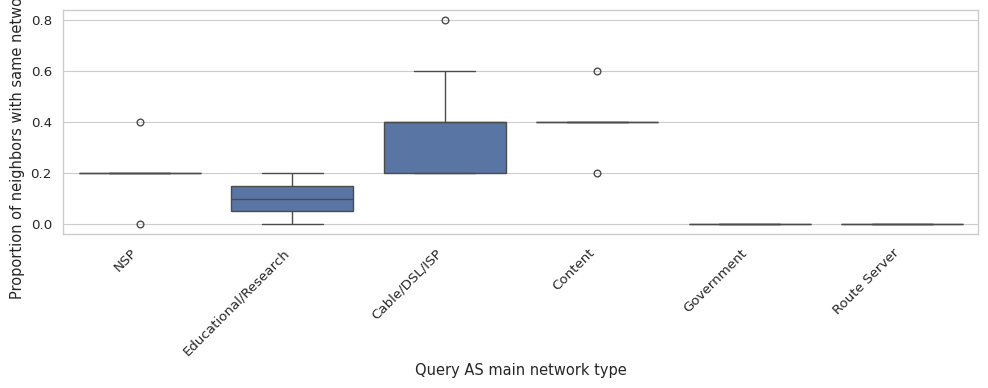

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="paper", font_scale=1.1)

# 例1：按 query_main_type 展示最近邻中 属性一致率的分布箱线图
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=agg,
    x="main_type",
    y="same_type_rate"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion of neighbors with same network type")
plt.xlabel("Query AS main network type")
plt.tight_layout()
plt.show()
# plt.savefig("fig_same_type_rate_by_type.pdf")
# plt.close()



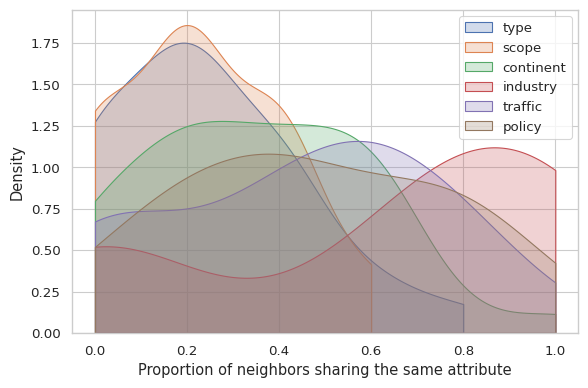

In [18]:
# 例2：各属性一致率的整体分布（不分 type）
plt.figure(figsize=(6, 4))
sns.kdeplot(agg["same_type_rate"], label="type", fill=True, clip=(0, 1), cut=0)
sns.kdeplot(agg["same_scope_rate"], label="scope", fill=True, clip=(0, 1), cut=0)
sns.kdeplot(agg["same_continent_rate"], label="continent", fill=True, clip=(0, 1), cut=0)
sns.kdeplot(agg["same_industry_rate"], label="industry", fill=True, clip=(0, 1), cut=0)
sns.kdeplot(agg["same_traffic_rate"], label="traffic", fill=True, clip=(0, 1), cut=0)
sns.kdeplot(agg["same_policy_rate"], label="policy", fill=True, clip=(0, 1), cut=0)

plt.xlabel("Proportion of neighbors sharing the same attribute")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("fig_same_attr_rate_overall.pdf")
# plt.close()

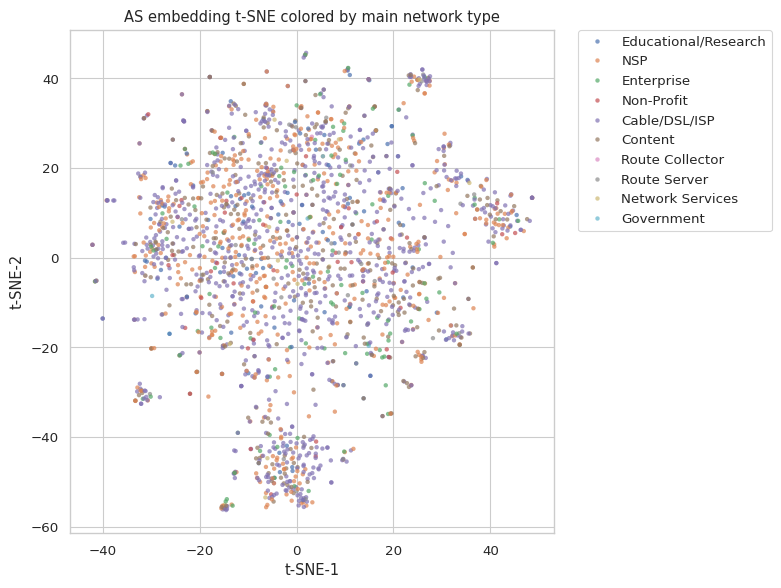

In [16]:
from sklearn.manifold import TSNE
# 或者 UMAP
# import umap

# 只对 df_core 的 embedding 做一次 t-SNE 降维
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto")
emb_2d = tsne.fit_transform(emb_mat)  # (N, 2)

df_vis = df_core.copy()
df_vis["x"] = emb_2d[:, 0]
df_vis["y"] = emb_2d[:, 1]

# 例：按 main_type 上色
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_vis,
    x="x", y="y",
    hue="main_type",
    s=10,
    alpha=0.7,
    linewidth=0
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.title("AS embedding t-SNE colored by main network type")
plt.tight_layout()
plt.show()
# plt.savefig("fig_tsne_by_type.pdf")
# plt.close()